# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse PFC cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cupyx as cpx
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

# managed_memory オプションなどで RMM を初期化
rmm.reinitialize(managed_memory=True)

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)

import calculation_tool as ct
import gc

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:
import os
import urllib.request
import gzip
import shutil

url_list=[r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Fmatrix%2Emtx%2Egz"]

def download_file(url, dir, file_name):
    full_path = os.path.join(dir, file_name)
    urllib.request.urlretrieve(url, full_path)
    # 以下のコメントアウト部分を活用する場合は、解凍の手順を追加することができます。
    # with gzip.open(full_path, 'rb') as f_in:
    #     with open(full_path[:-3], 'wb') as f_out:
    #         shutil.copyfileobj(f_in, f_out)

dir = "/data/mouse_PFC/"

for url in url_list:
    acc = url.split("acc=")[1].split("&")[0]
    file_name_from_url = url.split("file=")[1]

    # WTとSetd1aHetのサブフォルダを作成
    subfolder = "WT" if "WT" in file_name_from_url else "Setd1aHet"
    acc_dir = os.path.join(dir,subfolder, acc)
    os.makedirs(acc_dir, exist_ok=True)

    # 標準的なファイル名に変更（.gzを取り除く）
    standard_file_name = file_name_from_url.split('_')[-1].replace('.gz', '')
    
    if "barcodes" in file_name_from_url:
        standard_file_name = "barcodes.tsv.gz"
    elif "features" in file_name_from_url:
        standard_file_name = "features.tsv.gz"
    elif "matrix" in file_name_from_url:
        standard_file_name = "matrix.mtx.gz"
    
    # ファイルをダウンロード
    download_file(url, acc_dir, standard_file_name)


In [ ]:
# ダウンロードディレクトリ
base_dir = "/data/mouse_PFC/"

def read_10x_mtx(path, label):
    """10x mtxフォーマットのデータを読み込み、指定されたラベルを追加します。"""
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=True
    )
    adata.obs['label'] = label
    return adata

labels = ["WT", "Setd1aHet"]

all_adatas = []

for label in labels:
    label_dir = os.path.join(base_dir, label)
    gsm_dirs = [os.path.join(label_dir, d) for d in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, d))]
    
    for gsm_dir in gsm_dirs:
        if os.path.exists(gsm_dir):
            all_adatas.append(read_10x_mtx(gsm_dir, label))

# 全てのAnnDataオブジェクトを1つに結合
combined_adata = all_adatas[0].concatenate(all_adatas[1:], join='outer')

# .h5ad形式で保存
combined_adata.write("/data/mouse_PFC/combined_data.h5ad")

## load data

In [ ]:
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

preprocess_in_bulk
HTR1E is not included
HTR1E is removed from marker list
DRD3 is not included
DRD3 is removed from marker list
CHRM4 is not included
CHRM4 is removed from marker list
ADRA2B is not included
ADRA2B is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2C', 'ADRB1', 'ADRB2']
perform regression
perform scale
float32
Total Preprocessing time: 21.816910982131958
shape of adata: (27469, 21673)
shape of adata: (27469, 21673)
perform PCA
10
t-sne
UMAP
[2025-04-10 11:40:20.549] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP louvain


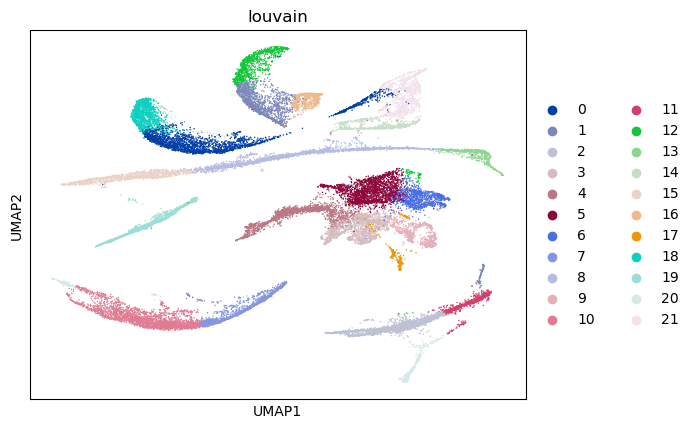

UMAP leiden


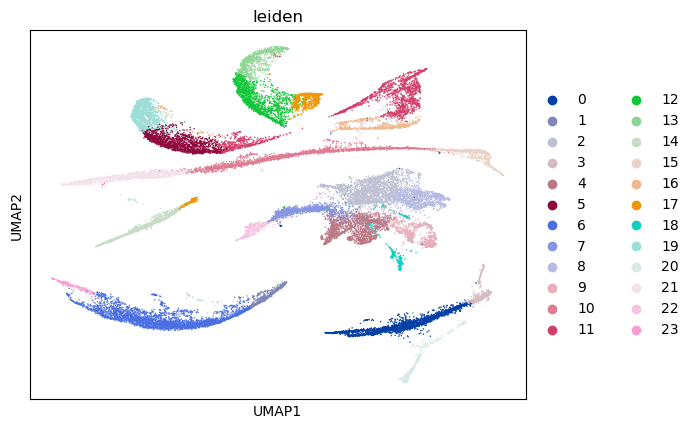

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    27123
True       346
Name: count, dtype: int64


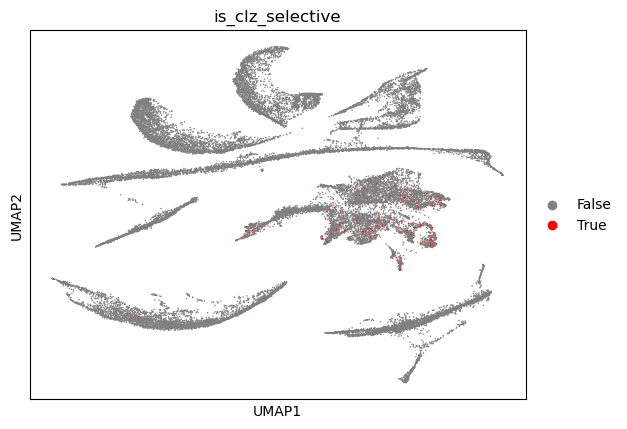

In [21]:
import calculation_tool as ct
file_path="/data/mouse_PFC/combined_data.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None)
GPCR_df.to_csv("/data/mouse_PFC/combined_data_GPCR_df.csv")

In [22]:
import calculation_tool as ct
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    27391
True        78
Name: count, dtype: int64


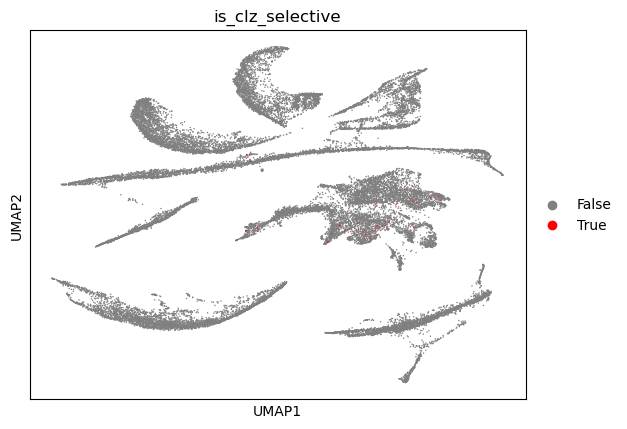

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    27391
True        78
Name: count, dtype: int64


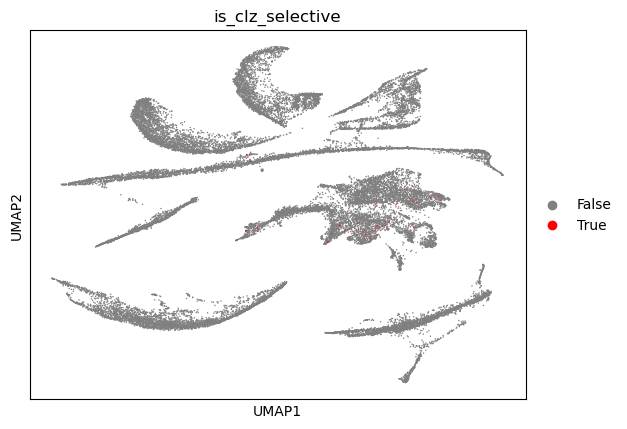

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    27391
True        78
Name: count, dtype: int64


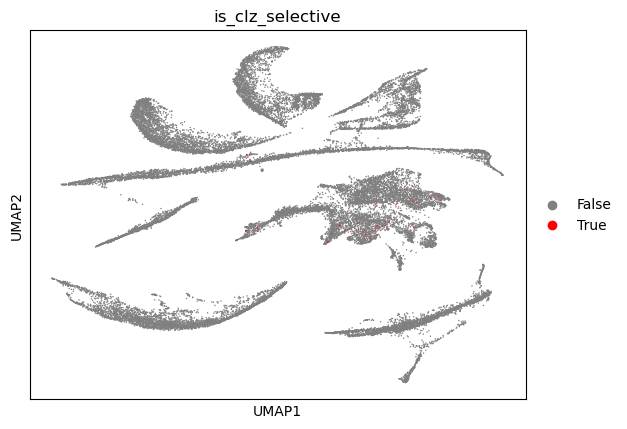

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    27385
True        84
Name: count, dtype: int64


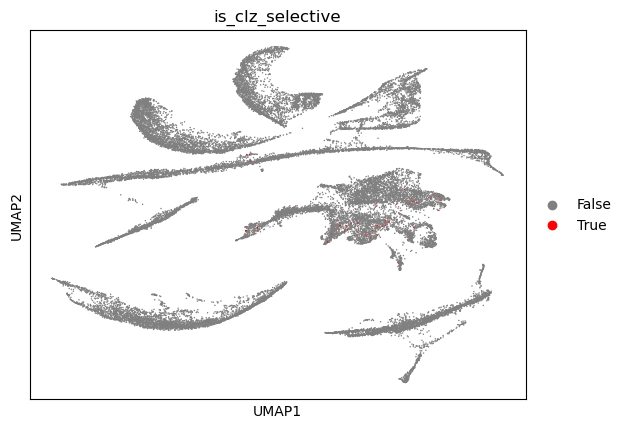

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    27378
True        91
Name: count, dtype: int64


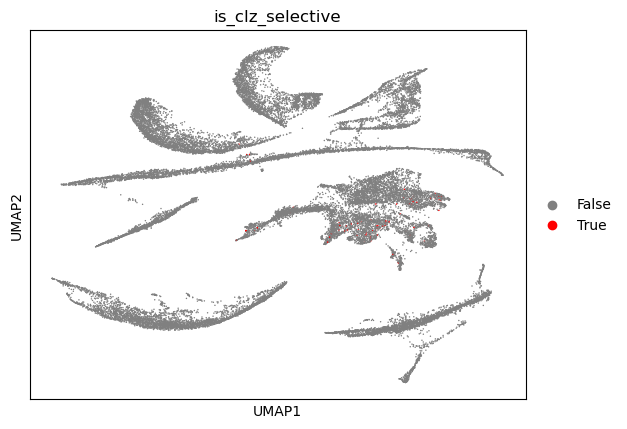

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    27376
True        93
Name: count, dtype: int64


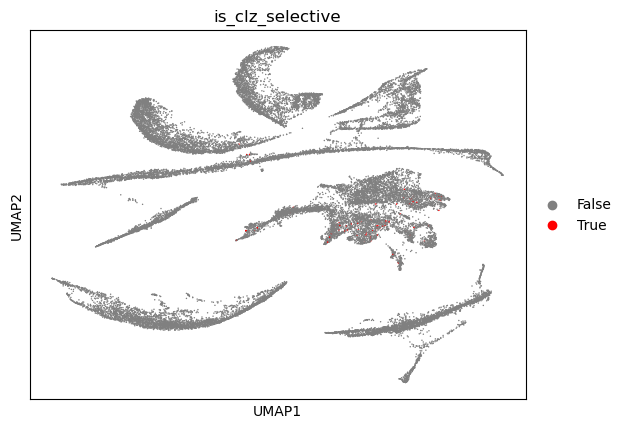

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    27219
True       250
Name: count, dtype: int64


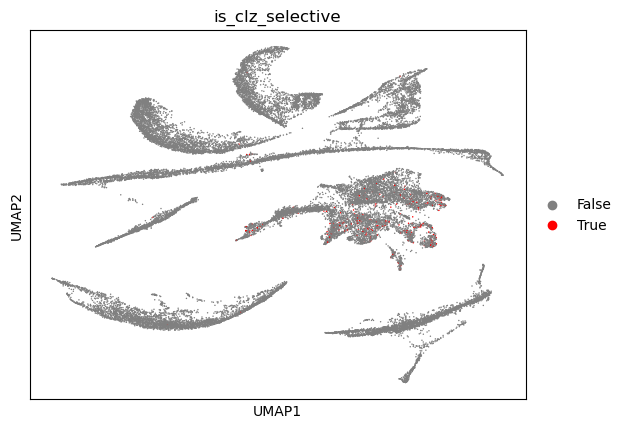

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    27177
True       292
Name: count, dtype: int64


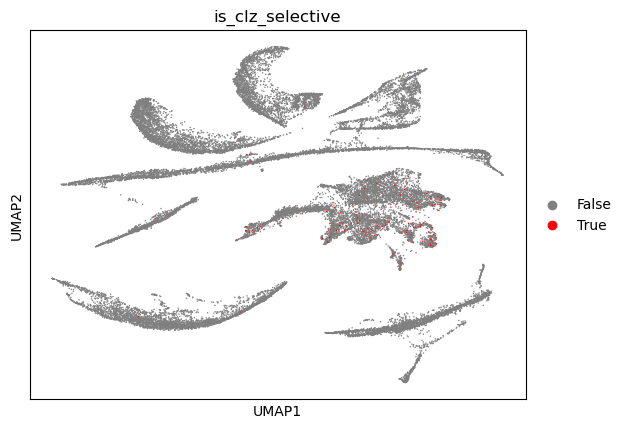

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    27169
True       300
Name: count, dtype: int64


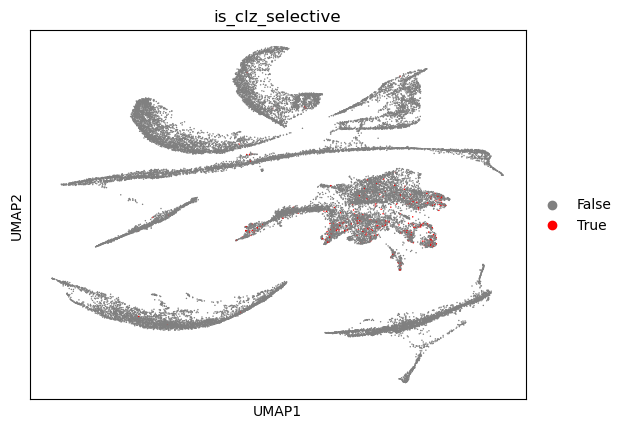

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    27158
True       311
Name: count, dtype: int64


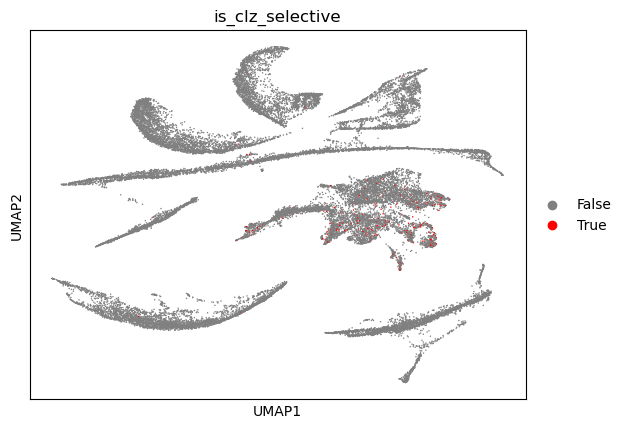

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    27135
True       334
Name: count, dtype: int64


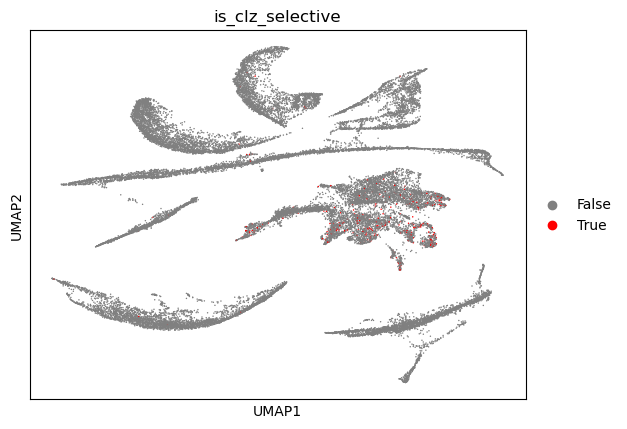

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    27133
True       336
Name: count, dtype: int64


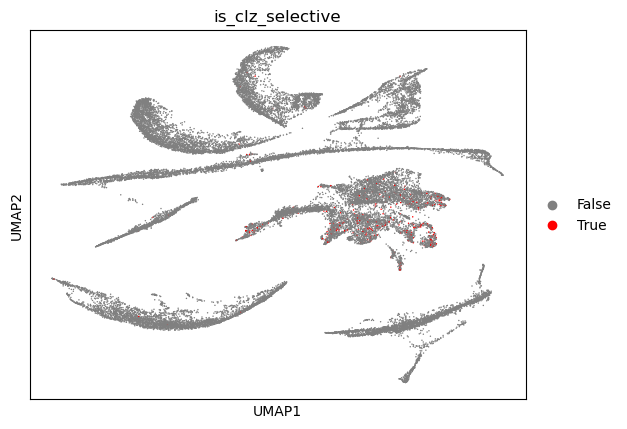

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    27142
True       327
Name: count, dtype: int64


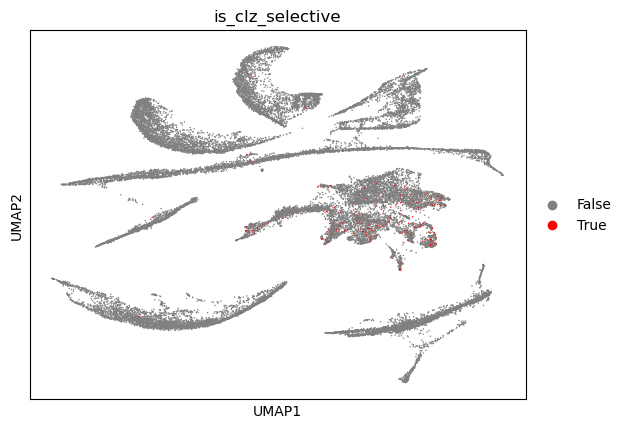

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    27201
True       268
Name: count, dtype: int64


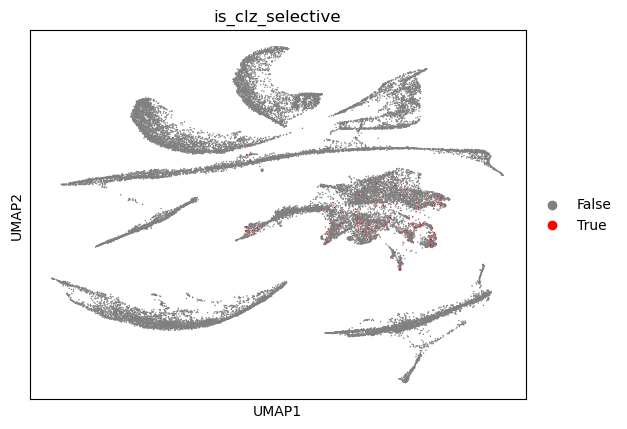

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    27257
True       212
Name: count, dtype: int64


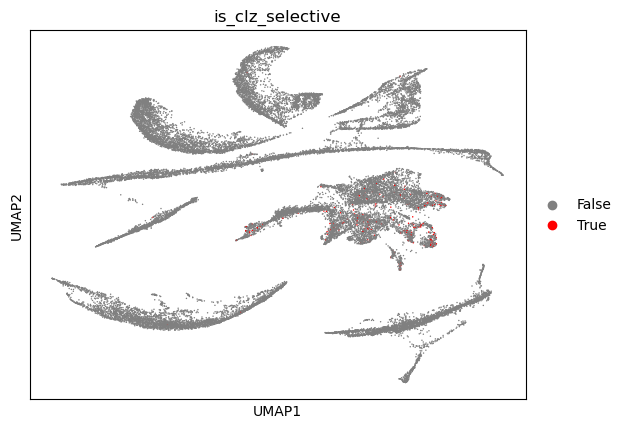

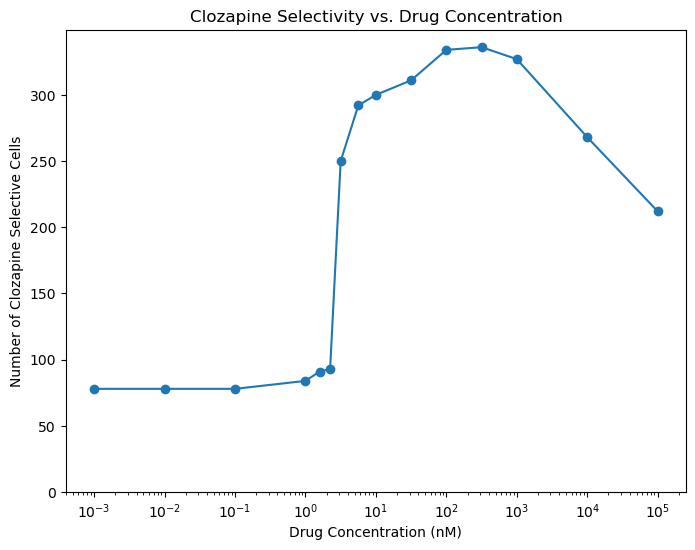

In [23]:
GPCR_df=pd.read_csv("/data/mouse_PFC/combined_data_GPCR_df.csv")
ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

clz selective cells
# of clz selective cells: is_clz_selective
False    27142
True       327
Name: count, dtype: int64


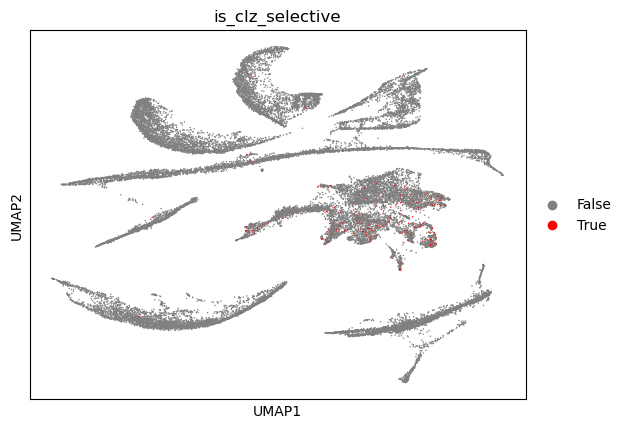

In [24]:
drug_conc=10**3
adata=ct.calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc)
selectivity_threshold=1.5
adata,num_clz_selective=ct.calc_clz_selective_cell(adata,drug_list,selectivity_threshold)

file_root, file_extension = os.path.splitext(file_path)
# Append '_processed' to the root and add the extension back
processed_file_path = f"{file_root}_processed{file_extension}"
adata.write(processed_file_path)

In [25]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)


In [26]:
import calculation_tool as ct

drug_conc=10**4
results_df_sorted,all_responses=ct.sim_inhibit_pattern(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,n_pattern=10000)

Pattern_1: {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': True, 'HTR5A_raw': True, 'HTR6_raw': True, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD4_raw': True, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': True, 'CHRM2_raw': True, 'CHRM3_raw': True, 'CHRM5_raw': True, 'ADRA1A_raw': True, 'ADRA1B_raw': True, 'ADRA2A_raw': True, 'ADRA2C_raw': False, 'ADRB1_raw': True, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': True, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': True, 'DRD2_raw': False, 'DRD4_raw': True, 'DRD5_raw': True, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': True, 'CHRM2_raw': True, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': F

Simulating drug responses: 100%|██████████| 10000/10000 [03:17<00:00, 50.73it/s]

      pattern_name                                            pattern  \
9434  Pattern_9435  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
5147  Pattern_5148  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
7855  Pattern_7856  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
2421  Pattern_2422  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
2616  Pattern_2617  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   

          diff  
9434  0.896231  
5147  0.896089  
7855  0.886467  
2421  0.886325  
2616  0.886044  


In [27]:
dir="/data/mouse_PFC"
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses.csv"))

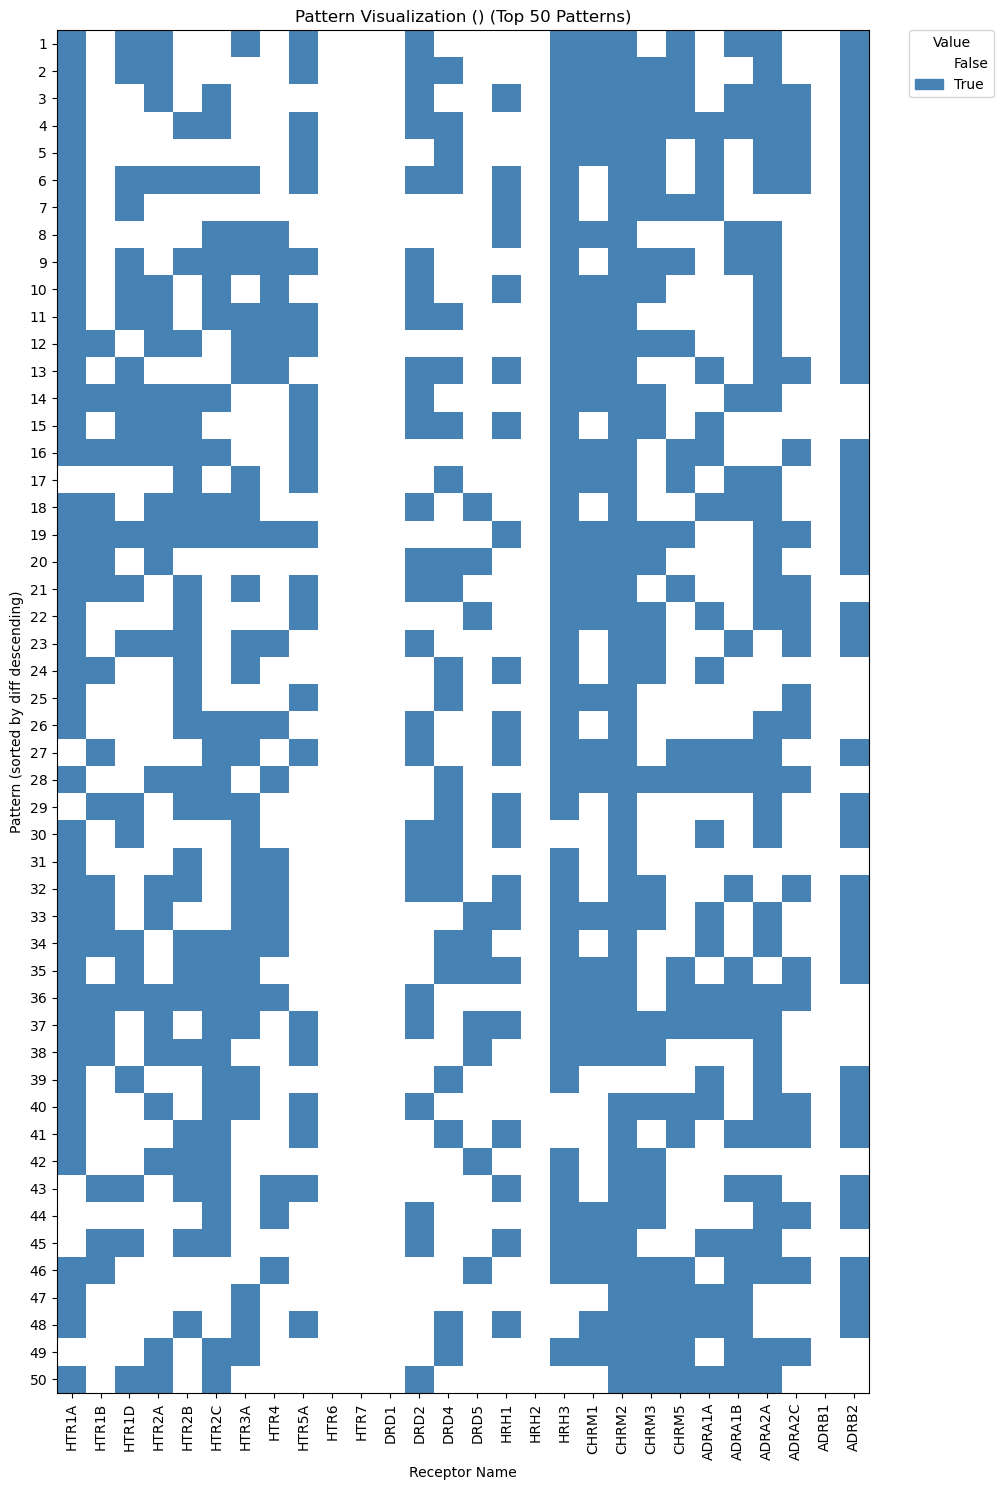

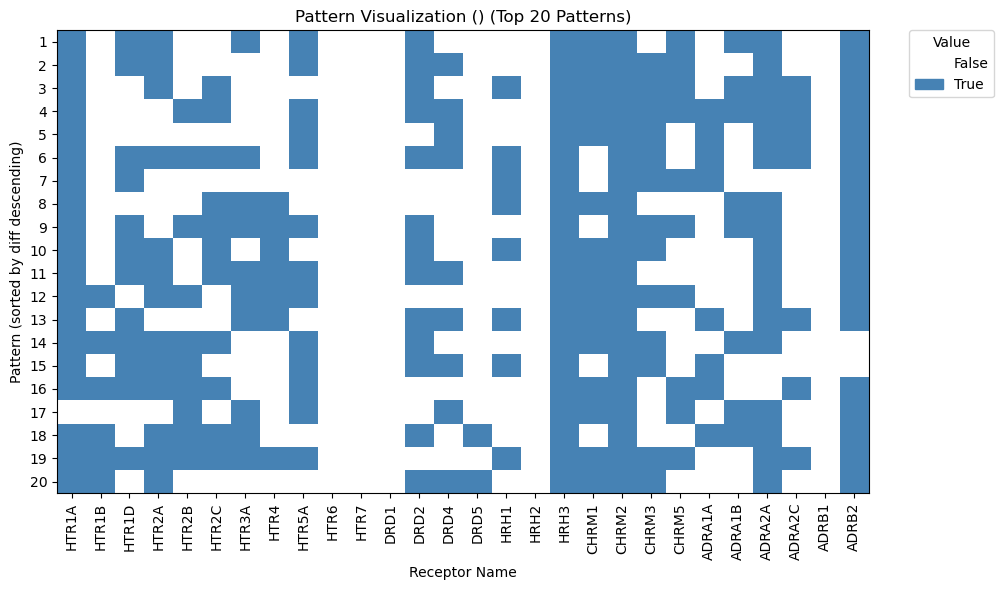

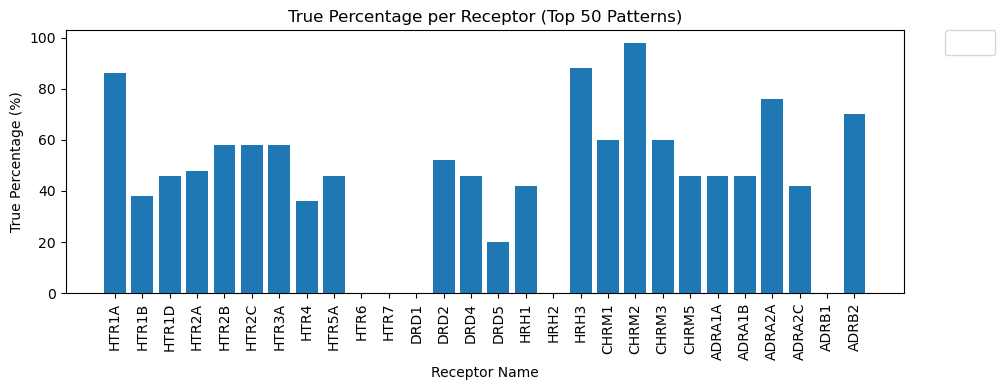

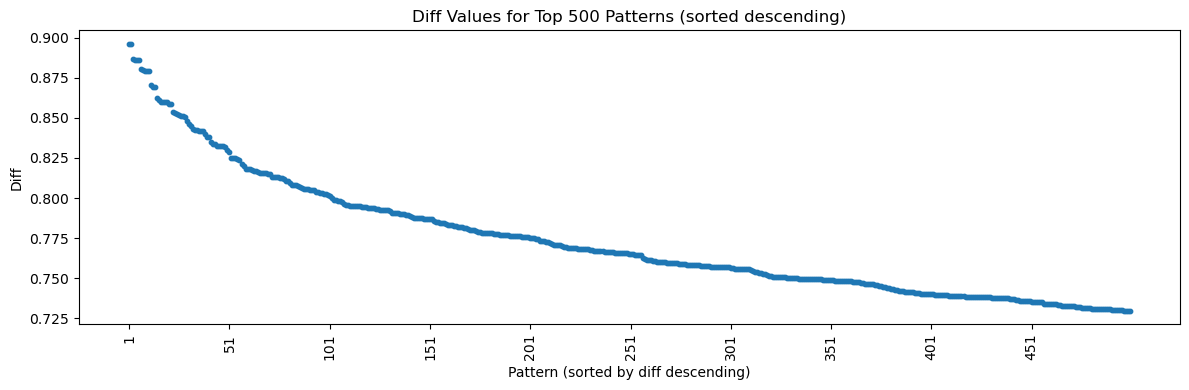

In [28]:
ct.visualize_patterns(results_df_sorted, top_n=50, top_n_for_heatmap=20, scatter_n=500)

Generating inhibition patterns: 100%|██████████| 3276/3276 [00:00<00:00, 213518.25it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False

Simulating drug responses:   0%|          | 4/3276 [00:00<01:27, 37.36it/s]

Simulating drug responses: 100%|██████████| 3276/3276 [01:05<00:00, 50.29it/s]


      pattern_name                                            pattern  \
297    Pattern_298  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
3127  Pattern_3128  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3124  Pattern_3125  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
322    Pattern_323  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
319    Pattern_320  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   

          diff  
297   1.568341  
3127  1.535318  
3124  1.530924  
322   1.513792  
319   1.509397  


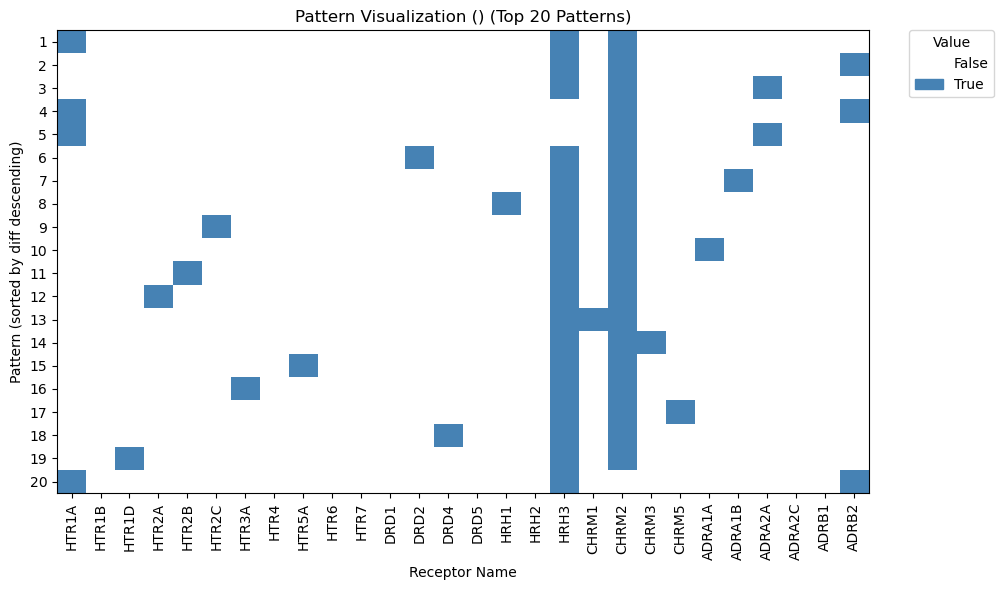

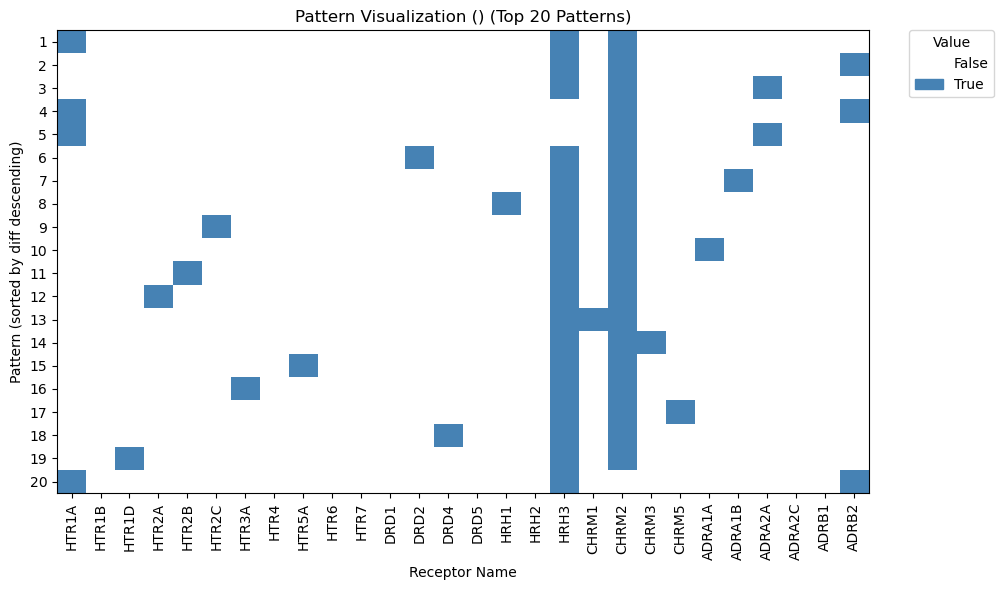

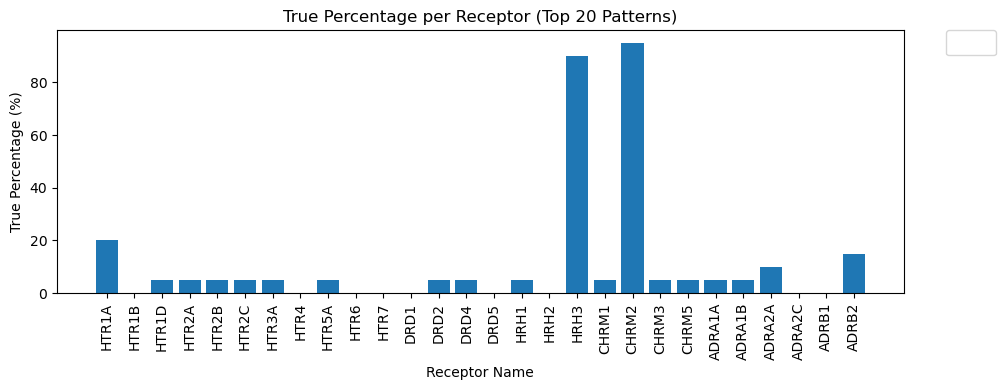

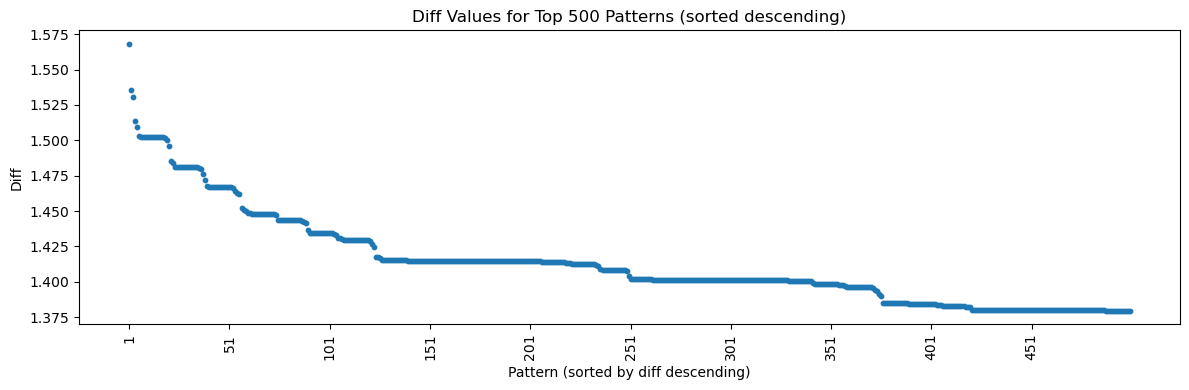

In [29]:
import calculation_tool as ct

drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc)
dir="/data/mouse_PFC"
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=500)

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
sc.pl.violin(
    adata,
    keys=['cAMP_CLOZAPINE',"cAMP_RISPERIDONE","cAMP_HALOPERIDOL"],  # Y軸に表示する変数
    groupby='leiden',       # X軸に leiden クラスタを使用
    jitter=True,            # データ点のばらつきを表示（オプション）
    stripplot=False,         # ストリッププロットを追加（オプション）
    legend=False
    
)